In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline

df1 = pd.read_csv("jan20_p.csv", sep=";")
df2 = pd.read_csv("jan21_p.csv", sep=';')
df1.head()
df2.head()



,Unnamed: 0,Twits,Valence,Arousal,Dominance
0,0,RT biz eğitim dilenmeye devam bilim kurulu üye...,3.18,2.57,3.08
1,1,RT Korona olmayan kaç kişi kaldı Böylelikle va...,3.35,2.38,3.25
2,2,RT _ Kargo ile ucuz yağ satacağını açıklayan ü...,3.24,2.64,3.29
3,3,RT Arjantin Covid19la mücadele için gerekli ol...,3.26,2.53,3.20
4,4,RT Korona geçmeden herkes aşılanmadan kimse ka...,3.29,2.91,2.95


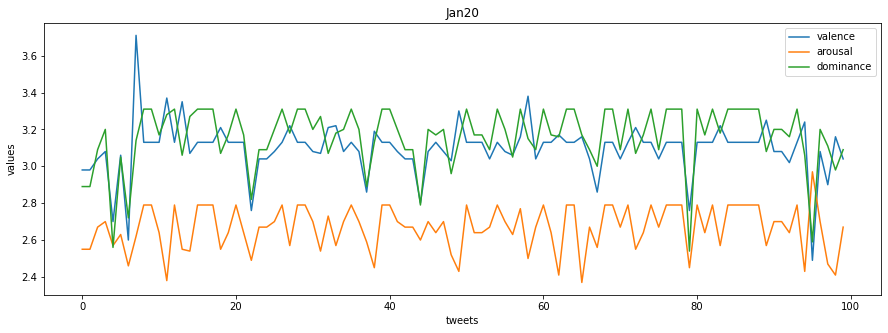

In [9]:
df1_v = df1["Valence"]
df1_a = df1["Arousal"]
df1_d = df1["Dominance"]
x = df1.index
plt.rcParams["figure.figsize"] = (15, 5)
plt.plot(x, df1_v, label='valence')
plt.plot(x, df1_a, label='arousal')
plt.plot(x, df1_d, label='dominance')
plt.xlabel('tweets')
plt.ylabel('values')
plt.title("Jan20")
plt.legend()


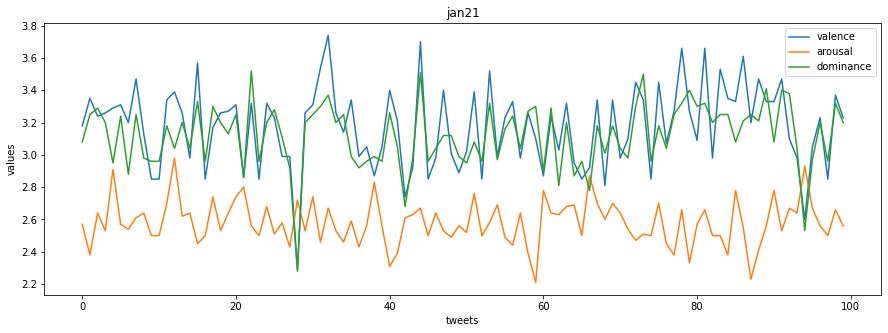

In [10]:
df2_v = df2["Valence"]
df2_a = df2["Arousal"]
df2_d = df2["Dominance"]
x2 = df2.index
plt.rcParams["figure.figsize"] = (15, 5)
plt.plot(x2, df2_v, label='valence')
plt.plot(x2, df2_a, label='arousal')
plt.plot(x2, df2_d, label='dominance')
plt.xlabel('tweets')
plt.ylabel('values')
plt.title("jan21")
plt.legend()

In [26]:
#Testing for valence 
df1_valence = df1['Valence'].values.astype(float)
df1_valence

df1_valence_test_size = 10
df1_valence_train_data = df1_valence[:-df1_valence_test_size]
df1_valence_test_data = df1_valence[-df1_valence_test_size:]
print(len(df1_valence_train_data), len(df1_valence_test_data))

#Normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
df1_valence_train_data_N = scaler.fit_transform(df1_valence_train_data.reshape(-1,1))


90 10


In [27]:
df1_valence_train_data_N = torch.FloatTensor(df1_valence_train_data_N).view(-1)
train_windows = 10

def create_inout_sequences(input_data, train_window):
    inout_seq = []
    L = len(input_data)
    for i in range(L-train_window):
        train_seq = input_data[i:i+train_window]
        train_label = input_data[i+train_window:i+train_window+1]
        inout_seq.append((train_seq, train_label))
        
    return inout_seq

train_inout_seq = create_inout_sequences(df1_valence_train_data_N, train_windows)
train_inout_seq

[(tensor([-0.3153, -0.3153, -0.2072, -0.1351, -0.8198, -0.1712, -1.0000,  1.0000,
          -0.0450, -0.0450]),
  tensor([-0.0450])),
 (tensor([-0.3153, -0.2072, -0.1351, -0.8198, -0.1712, -1.0000,  1.0000, -0.0450,
          -0.0450, -0.0450]),
  tensor([0.3874])),
 (tensor([-0.2072, -0.1351, -0.8198, -0.1712, -1.0000,  1.0000, -0.0450, -0.0450,
          -0.0450,  0.3874]),
  tensor([-0.0450])),
 (tensor([-0.1351, -0.8198, -0.1712, -1.0000,  1.0000, -0.0450, -0.0450, -0.0450,
           0.3874, -0.0450]),
  tensor([0.3514])),
 (tensor([-0.8198, -0.1712, -1.0000,  1.0000, -0.0450, -0.0450, -0.0450,  0.3874,
          -0.0450,  0.3514]),
  tensor([-0.1532])),
 (tensor([-0.1712, -1.0000,  1.0000, -0.0450, -0.0450, -0.0450,  0.3874, -0.0450,
           0.3514, -0.1532]),
  tensor([-0.0450])),
 (tensor([-1.0000,  1.0000, -0.0450, -0.0450, -0.0450,  0.3874, -0.0450,  0.3514,
          -0.1532, -0.0450]),
  tensor([-0.0450])),
 (tensor([ 1.0000, -0.0450, -0.0450, -0.0450,  0.3874, -0.0450, 

In [18]:
#Creating the LSTM
#Input size= represents features that will be used. In this example "passengers"
#Hidden layer size = represents amount of neurons in each layer

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size), torch.zeros(1,1,self.hidden_layer_size))
        
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [22]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [28]:
#Training

epochs = 200
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1,1,model.hidden_layer_size), torch.zeros(1,1,model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        
    if i%25 == 0:
        print(f"epoch: {i:3} | loss: {single_loss.item():10.8f}")
        
print(f"epoch: {i:3} | loss: {single_loss.item():10.8f}")
        
        
        

epoch:   0 | loss: 0.05796568
epoch:  25 | loss: 0.03754399
epoch:  50 | loss: 0.03163734
epoch:  75 | loss: 0.03365340
epoch: 100 | loss: 0.01939177
epoch: 125 | loss: 0.02888345
epoch: 150 | loss: 0.00503562
epoch: 175 | loss: 0.04237094
epoch: 199 | loss: 0.01000034


In [30]:
future_pred = 10
df1_test_inputs = df1_valence_train_data_N[-train_windows:].tolist()

model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(df1_test_inputs[-train_windows:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_layer_size), torch.zeros(1,1,model.hidden_layer_size))
        df1_test_inputs.append(model(seq).item())

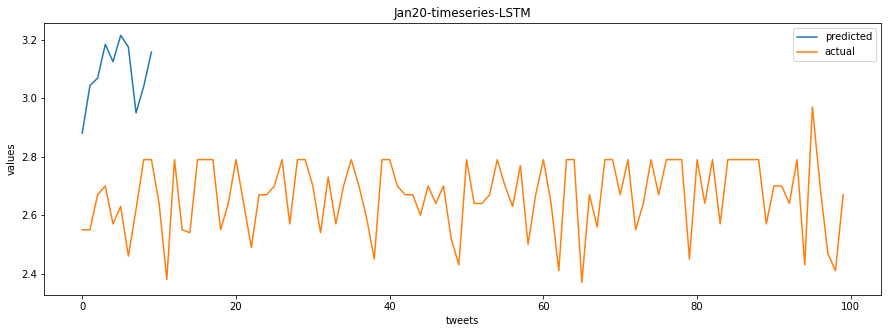

In [36]:
#De-normalization
df1_actual_pred = scaler.inverse_transform(np.array(df1_test_inputs[train_windows:]).reshape(-1,1))
#Plot

plt.plot( df1_actual_pred, label='predicted')
plt.plot( df1_a, label='actual')
plt.xlabel('tweets')
plt.ylabel('values')
plt.title("Jan20-timeseries-LSTM")

plt.legend()

In [34]:
df1_actual_pred

array([[2.88043726],
       [3.04280303],
       [3.06878163],
       [3.18398905],
       [3.12492773],
       [3.21488042],
       [3.17513774],
       [2.94976095],
       [3.04065119],
       [3.15771865]])